In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.stats.libqsturng import qsturng
from statsmodels.stats.multicomp import MultiComparison
import matplotlib.pyplot as plt

In [2]:
def f_test_variances(x1, x2, sides, alpha):
    # Convert input to NumPy arrays
    a1 = np.array(x1)
    a2 = np.array(x2)

    # Initialize results array
    result = np.full((7, 2), None, dtype=float)
    
    # Calculate basic statistics
    result[0] = [np.mean(a1), np.mean(a2)]                    # Means
    result[1] = [np.std(a1, ddof=1), np.std(a2, ddof=1)]      # Sample standard deviations
    result[2] = [a1.size, a2.size]                            # Sample sizes

    # Degrees of freedom
    dfn, dfd = a1.size - 1, a2.size - 1
    result[3] = [dfn, dfd]

    # F-statistic: ratio of sample variances
    f_stat = np.var(a1, ddof=1) / np.var(a2, ddof=1)
    result[4, 0] = f_stat

    # Critical F-values
    if sides > 1:
        result[5] = [
            stats.f.isf(alpha / 2, dfn, dfd),  # Upper critical value
            stats.f.ppf(alpha / 2, dfn, dfd)   # Lower critical value
        ]
    else:
        result[5] = [
            stats.f.isf(alpha, dfn, dfd),      # One-sided critical value
            stats.f.ppf(alpha, dfn, dfd)
        ]

    # P-value calculation
    if f_stat > 1:
        p_value = 1 - stats.f.cdf(f_stat, dfn, dfd)
    else:
        p_value = stats.f.cdf(f_stat, dfn, dfd)
    if sides > 1:
        p_value *= 2
    result[6, 0] = p_value

    # Create labeled DataFrame
    labels = ['Mean', 'Std Dev', 'Size', 'Degrees of Freedom', 'F-statistic', 'F-critical', 'p-value']
    df = pd.DataFrame(result, index=labels)

    return df

""" Testcase """
x1 = [9.2, 8.5, 9.6, 8.9, 9.1]   # Sample 1
x2 = [8.3, 7.8, 7.6, 8.1, 7.9]   # Sample 2
sides = 2                        # Two-tailed test
alpha = 0.05                     # 5% significance level

# Run the test
result_df = f_test_variances(x1, x2, sides, alpha)

# Display the result
print(result_df)


                           0         1
Mean                9.060000  7.940000
Std Dev             0.403733  0.270185
Size                5.000000  5.000000
Degrees of Freedom  4.000000  4.000000
F-statistic         2.232877       NaN
F-critical          9.604530  0.104118
p-value             0.455697       NaN


In [3]:
def t_test_two_means_unequal_variance(x1, x2, sides, alpha, H0_diff):
    # Convert inputs to NumPy arrays
    a1 = np.array(x1)
    a2 = np.array(x2)

    # Initialize results array
    result = np.full((8, 2), None, dtype=float)

    # Basic statistics
    mean1, mean2 = np.mean(a1), np.mean(a2)
    var1, var2 = np.var(a1, ddof=1), np.var(a2, ddof=1)
    n1, n2 = a1.size, a2.size

    result[0] = [mean1, mean2]  # Means
    result[1] = [var1, var2]    # Variances
    result[2] = [n1, n2]        # Sample sizes

    # Mean difference and its variance
    mean_diff = mean1 - mean2
    diff_var = var1 / n1 + var2 / n2

    # Hypothesized difference under H0
    result[3, 0] = H0_diff

    # Degrees of freedom (Welch-Satterthwaite equation)
    numerator = diff_var ** 2
    denominator = (var1**2 / (n1**2 * (n1 - 1))) + (var2**2 / (n2**2 * (n2 - 1)))
    df = numerator / denominator
    result[4, 0] = df

    # t-statistic
    t_stat = (mean_diff - H0_diff) / np.sqrt(diff_var)
    result[5, 0] = t_stat

    # Critical t-values
    if sides > 1:
        result[6] = [stats.t.isf(alpha / 2, df), stats.t.ppf(alpha / 2, df)]
    else:
        result[6] = [stats.t.isf(alpha, df), stats.t.ppf(alpha, df)]

    # p-value
    if t_stat > 0:
        p_value = 1 - stats.t.cdf(t_stat, df)
    else:
        p_value = stats.t.cdf(t_stat, df)
    if sides > 1:
        p_value *= 2
    result[7, 0] = p_value

    # Create labeled DataFrame
    labels = [
        'Mean', 'Variance', 'Size', 'H0 Diff',
        'Degrees of Freedom', 't-statistic', 't-critical', 'p-value'
    ]
    df = pd.DataFrame(result, index=labels)

    return df

""" Testcase """
x1 = [12.3, 11.7, 12.9, 12.5, 12.1]
x2 = [11.0, 10.6, 10.8, 11.2, 10.9]
sides = 2        # Two-tailed test
alpha = 0.05     # 5% significance level
H0_diff = 0      # Null hypothesis: means are equal

# Run the t-test
result_df = t_test_two_means_unequal_variance(x1, x2, sides, alpha, H0_diff)

# Print the result
print(result_df)


                            0          1
Mean                12.300000  10.900000
Variance             0.200000   0.050000
Size                 5.000000   5.000000
H0 Diff              0.000000        NaN
Degrees of Freedom   5.882353        NaN
t-statistic          6.260990        NaN
t-critical           2.458824  -2.458824
p-value              0.000831        NaN


In [4]:

def run_t_test_summary(df, col1, col2, usevar='pooled', alpha=0.05):
    """
    Runs a t-test using statsmodels' CompareMeans and prints a summary.

    Parameters:
    - df: DataFrame containing the columns
    - col1, col2: Column names to compare
    - usevar: 'pooled' (equal variances) or 'unequal' (Welch)
    - alpha: Significance level
    """
    group1 = sms.DescrStatsW(df[col1].values)
    group2 = sms.DescrStatsW(df[col2].values)
    t_test = sms.CompareMeans(group1, group2)
    
    return t_test.summary(usevar=usevar, alpha=alpha)

""" Testcase """
# Create mock data
df_test = pd.DataFrame({
    'Method A': [10.2, 9.8, 10.0, 10.1, 10.4],
    'Method B': [9.5, 9.6, 9.7, 9.4, 9.8]
})

# Run t-test summary
print(run_t_test_summary(df_test, 'Method A', 'Method B', usevar='pooled', alpha=0.05))

                          Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1      0.5000      0.122      4.082      0.004       0.218       0.782


In [5]:
def oneway_anova(df, response_col, factor_col):
    """
    Runs a one-way ANOVA on the given dataframe.
    
    Parameters:
    - df: pandas DataFrame containing the data
    - response_col: name of the numeric response variable
    - factor_col: name of the categorical factor

    Returns:
    - ANOVA summary table (DataFrame)
    """
    
    formula = f'{response_col} ~ C({factor_col})'
    model = smf.ols(formula, data=df).fit()
    aov_table = sms.anova_lm(model, typ=2)
    
    print("\nANOVA Table:")
    display(aov_table)
    
    return aov_table

""" Testcase """
# Create mock data
df_test = pd.DataFrame({
    'sale': [10, 12, 13, 14, 15, 16, 15, 14, 13],
    'factor': ['A', 'A', 'A', 'B', 'B', 'B', 'C', 'C', 'C']
})

# Run ANOVA
result = oneway_anova(df_test, 'sale', 'factor')


ANOVA Table:


,sum_sq,df,F,PR(>F)
C(factor),17.555556,2.0,6.076923,0.036103
Residual,8.666667,6.0,NaN,NaN


In [6]:
def shapiro_wilk_test(df, response_col, factor_col, alpha=0.05):
    """
    Runs Shapiro-Wilk test for normality on each group defined by a factor column.

    Parameters:
    - df: pandas DataFrame
    - response_col: Name of the response variable
    - factor_col: Name of the factor variable
    - alpha: Significance level for the Shapiro-Wilk test

    Returns:
    - A dictionary of test results per group
    """
    results = {}
    print(f"Shapiro-Wilk Test for Normality (alpha = {alpha}):\n")

    for level in df[factor_col].unique():
        group_data = df[response_col][df[factor_col] == level]
        stat, p = stats.shapiro(group_data)
        results[level] = {'Shapiro Statistic': stat, 'p-value': p}
        
        print(f"For factor = {level}")
        print(f"  Shapiro statistic = {stat:.6f}, p-value = {p:.6f}", end=" ")
        if p > alpha:
            print("→ Likely Normal")
        else:
            print("→ Not Normal")
    
    return results

""" Testcase """
# Example DataFrame
df_test = pd.DataFrame({
    'sale': [10, 11, 9, 13, 14, 15, 18, 19, 100],
    'factor': ['convnce', 'convnce', 'convnce', 'quality', 'quality', 'quality', 'price', 'price', 'price']
})

# Run normality test
normality_results = shapiro_wilk_test(df_test, 'sale', 'factor')


Shapiro-Wilk Test for Normality (alpha = 0.05):

For factor = convnce
  Shapiro statistic = 1.000000, p-value = 1.000000 → Likely Normal
For factor = quality
  Shapiro statistic = 1.000000, p-value = 1.000000 → Likely Normal
For factor = price
  Shapiro statistic = 0.759145, p-value = 0.020294 → Not Normal


In [7]:
def bartlett_test(df, response_col, factor_col, alpha=0.05):
    """
    Performs Bartlett's test for equal variances across groups.

    Parameters:
    - df: pandas DataFrame
    - response_col: Name of the numeric response variable
    - factor_col: Name of the categorical factor variable
    - alpha: Significance level for the test

    Returns:
    - (statistic, p-value)
    """
    groups = df[factor_col].unique()
    data_by_group = [df[response_col][df[factor_col] == group] for group in groups]

    stat, p = stats.bartlett(*data_by_group)
    print("Bartlett’s Test for Equal Variances:")
    print(f"  Test statistic = {stat:.6f}, p-value = {p:.6f}", end=" ")

    if p > alpha:
        print("→ Equal variances assumed")
    else:
        print("→ Variances differ significantly")

    return stat, p

""" Testcase """
# Example dataset
df_test = pd.DataFrame({
    'sale': [10, 11, 9, 13, 14, 15, 18, 19, 17],
    'factor': ['convnce', 'convnce', 'convnce', 'quality', 'quality', 'quality', 'price', 'price', 'price']
})

# Run Bartlett’s test
stat, p = bartlett_test(df_test, 'sale', 'factor')

Bartlett’s Test for Equal Variances:
  Test statistic = 0.000000, p-value = 1.000000 → Equal variances assumed


Q critical value = 4.334134
Tukey Omega = 2.502314
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
convnce   price      9.0 0.0001  6.4948 11.5052   True
convnce quality      3.0 0.0242  0.4948  5.5052   True
  price quality     -6.0 0.0008 -8.5052 -3.4948   True
------------------------------------------------------


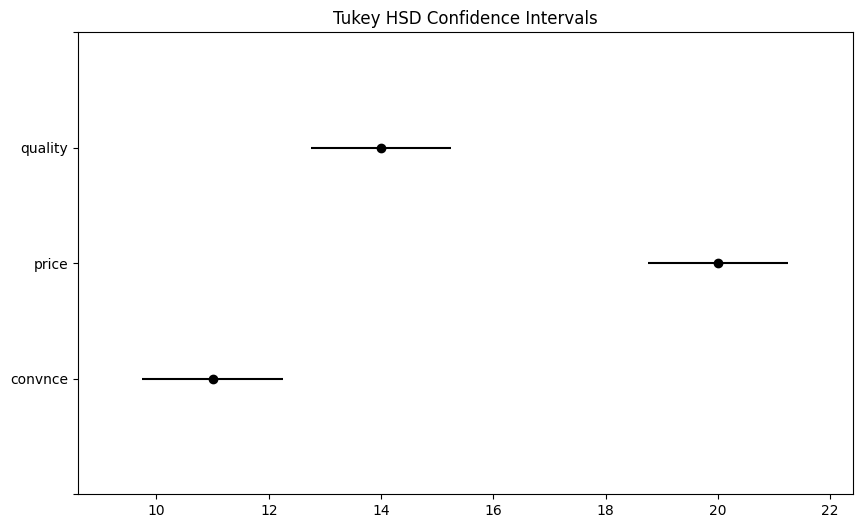

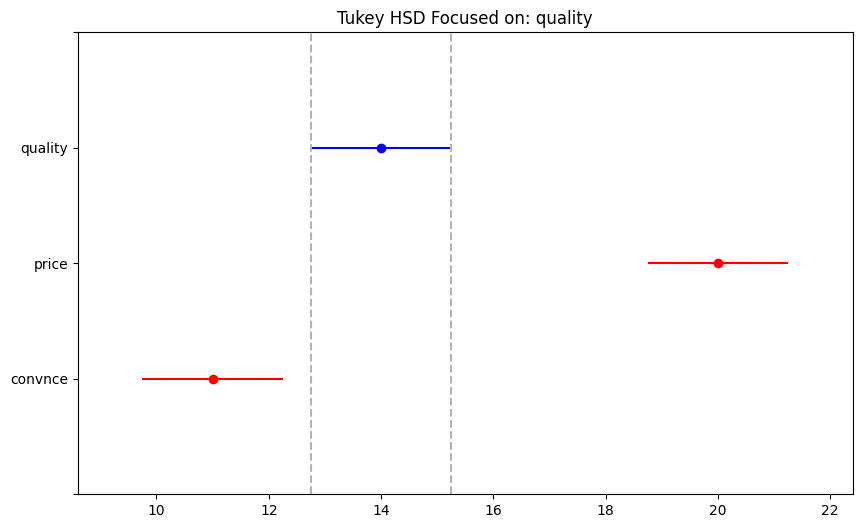

In [9]:
def tukey_hsd(df, response_col, factor_col, alpha=0.05, comparison_focus=None):
    """
    Performs Tukey's HSD test and plots confidence intervals.

    Parameters:
    - df: pandas DataFrame
    - response_col: Dependent variable
    - factor_col: Categorical independent variable
    - alpha: Significance level (default 0.05)
    - comparison_focus: Optional group name to center the plot on

    Returns:
    - Tuple of (summary table, omega)
    """
    # Number of groups and total degrees of freedom (from ANOVA)
    group_sizes = df.groupby(factor_col).size()
    k = len(group_sizes)
    df_within = df.shape[0] - k
    
    # Harmonic mean of group sizes (used in omega calculation)
    ng = k / np.sum(1 / group_sizes)

    # Get residual sum of squares from ANOVA
    model = smf.ols(f"{response_col} ~ C({factor_col})", data=df).fit()
    aov_table = sms.anova_lm(model, typ=2)
    mse = aov_table.loc["Residual", "sum_sq"] / aov_table.loc["Residual", "df"]

    # Q critical value
    q_crit = qsturng(1 - alpha, k, df_within)
    omega = q_crit * np.sqrt(mse / ng)

    # Run Tukey HSD
    tukey = MultiComparison(df[response_col], df[factor_col])
    tukey_result = tukey.tukeyhsd(alpha=alpha)

    # Print results
    print(f"Q critical value = {q_crit:.6f}")
    print(f"Tukey Omega = {omega:.6f}")
    print(tukey_result.summary())

    # Plot
    _ = tukey_result.plot_simultaneous()
    plt.title("Tukey HSD Confidence Intervals")
    plt.show()

    if comparison_focus:
        _ = tukey_result.plot_simultaneous(comparison_name=comparison_focus)
        plt.title(f"Tukey HSD Focused on: {comparison_focus}")
        plt.show()

    return tukey_result.summary(), omega

# Simulated example
df_test = pd.DataFrame({
    'sale': [10, 12, 11, 15, 13, 14, 20, 19, 21],
    'factor': ['convnce']*3 + ['quality']*3 + ['price']*3
})

summary, omega = tukey_hsd(df_test, response_col='sale', factor_col='factor', alpha=0.05, comparison_focus='quality')
